In [1]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization to /tmp/pip-req-build-m7m54rcu
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization /tmp/pip-req-build-m7m54rcu
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 298 kB 4.9 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=144999 sha256=01534b8670cd127a24dd3c2083706d5e0f6ca1c481b77f2670e9ef9a4fc34d6d
  Stored in directory: /tmp/pip-ephem-wheel-cache-qvb989yy/wheels/eb/7f/26/4a3835d3d83e17ac1d9bed33d09ecdd6dd423759b38e69c270
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=cd47ac3fbfc4965803fce4206dcf740ffe2bd11190988ddd86b76237d8468e30
  Stored in directory:

In [2]:
!pip3 install cma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 249 kB 5.3 MB/s 


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cma

from bayes_optim import BO
from bayes_optim.search_space import RealSpace
from bayes_optim.surrogate import GaussianProcess, trend

from benchmark.bbobbenchmarks import F10, F11, F12, F13, F14, F15, F16, F21

In [4]:
dim = 2
lb, ub = -5, 5

space = RealSpace([lb, ub]) * dim

mean = trend.constant_trend(dim, beta=None)
thetaL = 1e-10 * (ub - lb) * np.ones(dim)
thetaU = 10 * (ub - lb) * np.ones(dim)
theta0 = np.random.rand(dim) * (thetaU - thetaL) + thetaL

doe_sizes = (5, 10, 15, 20)
max_FEs = 50
verbose = False

n_samples = 1000

max_cma_iter = 10

In [5]:
opt_color, found_color, initial_color = "green", "red", "blue"


def plot(points, colors, ax=plt, outline=False, marker='o'):
    transposed = np.transpose(points)
    if outline:
        ax.scatter(transposed[0], transposed[1], color="none", edgecolor=colors, marker=marker)
    else:
        ax.scatter(transposed[0], transposed[1], c=colors, marker=marker)
  
def plot_result(func, samples, values, result, ax):
  plot(samples, values, ax=ax, outline=False)
  if result["initial_points"] is not None:
    plot(result["initial_points"], ["blue"] * result["initial_points"].shape[0], ax=ax, marker='^')
  ax.set_title(f'{result.get("description", "regret")}: {result["regret"]}', size=6)
  plot([func._getxopt(), result["found_x"]], [opt_color, found_color], ax=ax, marker='s')

In [6]:
def make_optimizer(obj_func, doe, random_seed=1):
    model = GaussianProcess(
        mean=mean,
        corr="squared_exponential",
        theta0=theta0,
        thetaL=thetaL,
        thetaU=thetaU,
        nugget=0,
        noise_estim=False,
        optimizer="BFGS",
        wait_iter=3,
        random_start=dim,
        likelihood="concentrated",
        eval_budget=100 * dim,
    )
    return BO(
        search_space=space,
        obj_fun=obj_func,
        model=model,
        DoE_size=len(doe),
        acquisition_fun="EI",
        initial_points=doe,
        max_FEs=max_FEs,
        verbose=verbose,
        n_point=1, 
        random_seed=random_seed
    )
    
def regret_function(obj_func, doe_size):
    def func(X):
        doe = np.split(X, doe_size)
        opt = make_optimizer(obj_func, doe)
        _, value, _ = opt.run()
        return value - obj_func.getfopt()
    return func

## Experiments

In [7]:
sigma0 = ub / 3 # the optimum is expected to lie within x0 +- 3 * sigma0

def cma_es_experiment(obj_function, doe_size, bo_seed=1, cma_seed=1111):
  regret_func = regret_function(obj_function, doe_size)
  doe_flattened, es = cma.fmin2(regret_func, np.zeros(doe_size * dim), sigma0, {'maxiter': max_cma_iter, 'seed': cma_seed})
  doe = np.split(doe_flattened, doe_size)
  opt = make_optimizer(obj_function, np.split(es.best.x, doe_size), bo_seed)
  x, value, _ = opt.run()
  samples = space.sample(n_samples)
  values = obj_function(samples)
  regret = value - obj_function.getfopt()
  print(f'Regret is: {regret}, Found x: {x}, Found f: {value}, Optimal f: {obj_function.getfopt()}, Optimum x: {obj_function._xopt}')
  plot_result(obj_func, samples, values, {"initial_points": np.array(doe), "regret": regret, "found_x": x}, plt.gca())
  return doe

In [8]:
def test_doe(obj_func, doe):
  result = []
  for i in range(len(doe)):
    removed_point = doe[i]
    reduced_doe = doe[:i] + doe[i + 1:]
    opt = make_optimizer(obj_func, reduced_doe)
    x, value, _ = opt.run()
    samples = space.sample(n_samples)
    values = obj_func(samples)
    regret = value - obj_func.getfopt()
    print(f'Regret is: {regret} without {removed_point}')
    result.append({"removed_point": removed_point, "regret": regret, "found_x": x, "found_f": value, "initial_points": reduced_doe})
  samples = space.sample(n_samples)
  values = obj_func(samples)
  plot_test(obj_func, samples, values, result)
  return result

In [9]:
def plot_test_result(func, samples, values, result, ax):
  plot(samples, values, ax=ax, outline=False)
  plot(result["initial_points"], ["blue"] * len(result["initial_points"]), ax=ax, marker='^')
  plot(result["removed_point"], ["blue"], ax=ax, marker='x')
  ax.set_title(f'{result.get("description", "regret")}: {result["regret"]}', size=6)
  plot([func._getxopt(), result["found_x"]], [opt_color, found_color], ax=ax, marker='s')

def plot_test(func, samples, values, results):
    fig, axs = plt.subplots(1, len(results))
    fig.suptitle("Objective function " + func.__class__.__name__, fontsize=8)
    for (result, ax) in zip(results, axs):
        plot_test_result(func, samples, values, result, ax)
    plt.show()

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1111, Tue Oct 18 20:35:22 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.628091392153920e-05 1.0e+00 1.62e+00  2e+00  2e+00 1:55.3
    2     20 8.906803385713147e-04 1.2e+00 1.55e+00  1e+00  2e+00 3:40.5
    3     30 3.752854983545717e-03 1.2e+00 1.49e+00  1e+00  2e+00 5:35.0
    4     40 9.667244995625879e-07 1.3e+00 1.46e+00  1e+00  2e+00 7:25.4
    5     50 1.220666489842870e-05 1.4e+00 1.39e+00  1e+00  1e+00 9:14.5
    6     60 2.917608205237343e-04 1.5e+00 1.40e+00  1e+00  1e+00 11:07.5
    7     70 1.780735718170945e-05 1.6e+00 1.40e+00  1e+00  1e+00 12:56.0
    8     80 8.795047789078581e-05 1.6e+00 1.44e+00  1e+00  2e+00 14:45.3
    9     90 1.233091966128086e-03 1.6e+00 1.48e+00  1e+00  2e+00 16:45.0
   10    100 3.313258016909515e-03 1.7e+00 1.53e+00  1e+00  2e+00 18:29.5
termination on maxiter=10 (Tue Oct 18 20:54:06 2022)
final/bestever f-value = 1.368375e+00 9.667245e-07

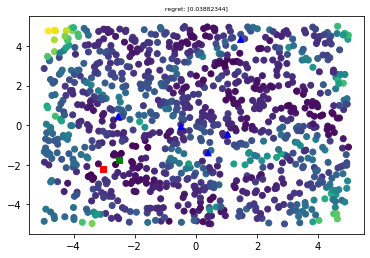

In [10]:
obj_func = F21(1)
doe_size = 5

doe = cma_es_experiment(obj_func, doe_size)

In [11]:
# remove each point from the doe and compute error

Regret is: [1.57782344] without [ 0.40204036 -1.40338228]
Regret is: [0.02343826] without [ 1.04102984 -0.46064789]
Regret is: [1.12634803] without [-0.48730358 -0.07900101]
Regret is: [0.69483309] without [-2.53830433  0.42365461]
Regret is: [0.00337033] without [1.4616707  4.33093987]


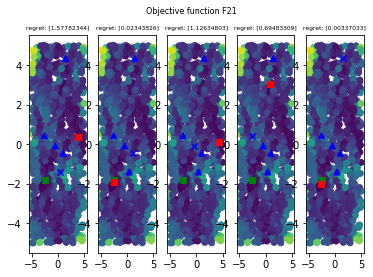

In [12]:
result = test_doe(obj_func, doe)

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=1111, Tue Oct 18 20:55:18 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.027352186632413e-03 1.0e+00 1.46e+00  1e+00  1e+00 1:48.8
    2     18 1.577850567276329e-02 1.2e+00 1.37e+00  1e+00  1e+00 3:27.1
    3     27 3.733981587963342e-03 1.3e+00 1.33e+00  1e+00  1e+00 5:05.6
    4     36 3.527550504145438e-06 1.3e+00 1.29e+00  1e+00  1e+00 6:46.3
    5     45 2.684340937190655e-02 1.5e+00 1.48e+00  1e+00  2e+00 8:23.2
    6     54 1.035816026109941e-01 1.6e+00 1.70e+00  1e+00  2e+00 10:01.3
    7     63 8.966722452683484e-04 1.9e+00 1.92e+00  2e+00  2e+00 11:42.2
    8     72 1.127282628488047e-05 2.1e+00 2.01e+00  2e+00  2e+00 13:26.8
    9     81 3.398098306746533e-03 2.2e+00 1.78e+00  1e+00  2e+00 15:04.0
   10     90 1.047159592921787e-03 2.1e+00 1.67e+00  1e+00  2e+00 16:43.4
termination on maxiter=10 (Tue Oct 18 21:12:13 2022)
final/bestever f-value = 2.047591e+00 3.527551e-06
i

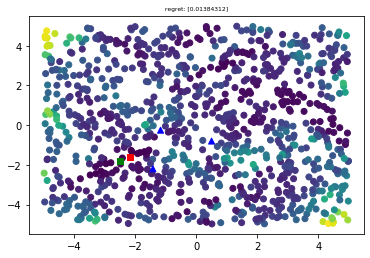

In [13]:
doe_size = 3

doe = cma_es_experiment(obj_func, doe_size)

Regret is: [5.23067524e-05] without [-1.1760163  -0.25408082]
Regret is: [0.00859165] without [ 0.49691097 -0.80288274]
Regret is: [1.11754737] without [-1.42522699 -2.19983841]


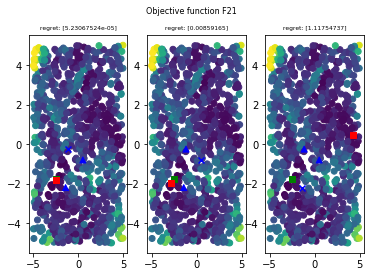

[{'removed_point': array([-1.1760163 , -0.25408082]),
  'regret': array([5.23067524e-05]),
  'found_x': [-2.5439843982195267, -1.8372215931701936],
  'found_f': array([40.78005231]),
  'initial_points': [array([ 0.49691097, -0.80288274]),
   array([-1.42522699, -2.19983841])]},
 {'removed_point': array([ 0.49691097, -0.80288274]),
  'regret': array([0.00859165]),
  'found_x': [-2.8095312870132285, -1.9549053840957664],
  'found_f': array([40.78859165]),
  'initial_points': [array([-1.1760163 , -0.25408082]),
   array([-1.42522699, -2.19983841])]},
 {'removed_point': array([-1.42522699, -2.19983841]),
  'regret': array([1.11754737]),
  'found_x': [4.235829691906681, 0.47948488986438786],
  'found_f': array([41.89754737]),
  'initial_points': [array([-1.1760163 , -0.25408082]),
   array([ 0.49691097, -0.80288274])]}]

In [14]:
test_doe(obj_func, doe)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 20 (seed=1111, Tue Oct 18 21:12:54 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 2.206459582438924e-04 1.0e+00 1.57e+00  2e+00  2e+00 1:56.4
    2     24 8.727949597044926e-04 1.1e+00 1.48e+00  1e+00  1e+00 3:56.9
    3     36 2.162789807869103e-05 1.1e+00 1.40e+00  1e+00  1e+00 5:53.7
    4     48 8.716867910152359e-06 1.2e+00 1.34e+00  1e+00  1e+00 7:53.7
    5     60 2.208553588900486e-06 1.2e+00 1.29e+00  1e+00  1e+00 9:55.9
    6     72 2.025436887400645e-03 1.2e+00 1.27e+00  1e+00  1e+00 11:50.6
    7     84 2.365774950590094e-04 1.2e+00 1.24e+00  1e+00  1e+00 13:53.8
    8     96 1.616257166276114e-03 1.2e+00 1.22e+00  1e+00  1e+00 15:49.8
    9    108 8.721451842532701e-04 1.2e+00 1.20e+00  1e+00  1e+00 17:54.7
   10    120 1.535873603506133e-02 1.3e+00 1.14e+00  1e+00  1e+00 19:57.0
termination on maxiter=10 (Tue Oct 18 21:33:00 2022)
final/bestever f-value = 1.261178e-01 2.208554e-06

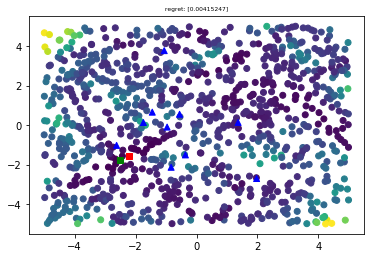

In [15]:
doe_size = 10

doe = cma_es_experiment(obj_func, doe_size)

Regret is: [0.01524576] without [1.3646421  0.13227144]
Regret is: [0.00023018] without [-1.74297579  0.13180262]
Regret is: [0.52786539] without [ 1.97156382 -2.70242944]
Regret is: [0.05415316] without [-0.83329268 -2.13369723]
Regret is: [0.00090442] without [-0.96517853 -0.10097764]
Regret is: [0.00329906] without [-0.36504831 -1.50878407]
Regret is: [0.01314857] without [-1.45259399  0.65373741]
Regret is: [0.00107857] without [-1.05995029  3.76574377]
Regret is: [2.70591715] without [-2.62282741 -1.02663532]
Regret is: [2.05611166] without [-0.55589569  0.54796639]


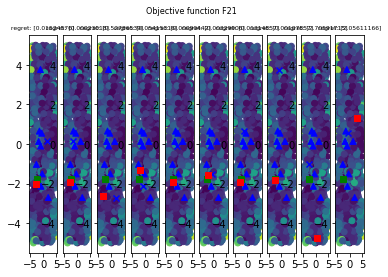

[{'removed_point': array([1.3646421 , 0.13227144]),
  'regret': array([0.01524576]),
  'found_x': [-2.6501725598660246, -2.0040663205595712],
  'found_f': array([40.79524576]),
  'initial_points': [array([-1.74297579,  0.13180262]),
   array([ 1.97156382, -2.70242944]),
   array([-0.83329268, -2.13369723]),
   array([-0.96517853, -0.10097764]),
   array([-0.36504831, -1.50878407]),
   array([-1.45259399,  0.65373741]),
   array([-1.05995029,  3.76574377]),
   array([-2.62282741, -1.02663532]),
   array([-0.55589569,  0.54796639])]},
 {'removed_point': array([-1.74297579,  0.13180262]),
  'regret': array([0.00023018]),
  'found_x': [-2.6611304753008587, -1.897272800257505],
  'found_f': array([40.78023018]),
  'initial_points': [array([1.3646421 , 0.13227144]),
   array([ 1.97156382, -2.70242944]),
   array([-0.83329268, -2.13369723]),
   array([-0.96517853, -0.10097764]),
   array([-0.36504831, -1.50878407]),
   array([-1.45259399,  0.65373741]),
   array([-1.05995029,  3.76574377]),
 

In [16]:
test_doe(obj_func, doe)